In [81]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/PROJET ANDL

ModuleNotFoundError: No module named 'google.colab'

In [82]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LSTM

from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.layers as tfkl
import tensorflow.keras as tfk

import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
X_train_1 = np.load('set/firbp_dataaugment/X_train.npy')
X_test_1 = np.load('set/firbp_dataaugment/X_test.npy')
X_val_1 = np.load('set/firbp_dataaugment/X_val.npy')

y_train_1 = np.load('set/firbp_dataaugment/y_train.npy')
y_test_1 = np.load('set/firbp_dataaugment/y_test.npy')
y_val_1 = np.load('set/firbp_dataaugment/y_val.npy')

In [84]:
print(f'X_train shape = {np.shape(X_train_1)} \nX_val shape = {np.shape(X_test_1)}\nX_test shape = {np.shape(X_val_1)}')

X_train shape = (223881, 701) 
X_val shape = (27986, 701)
X_test shape = (27985, 701)


# Neural Network Normal/Abnormal

In [85]:
y_train_2, y_test_2, y_val_2 = y_train_1, y_test_1, y_val_1

for i in range(len(y_train_1)):
    if y_train_1[i] == "S" or y_train_1[i] == "V" : y_train_2[i] = "A"
for i in range(len(y_test_1)):
    if y_test_1[i] == "S" or y_test_1[i] == "V" : y_test_2[i] = "A"
for i in range(len(y_val_1)):
    if y_val_1[i] == "S" or y_val_1[i] == "V" : y_val_2[i] = "A"

In [86]:
mapping = {"A": 1, "N": 0}

# Initialiser le LabelEncoder
label_encoder = LabelEncoder()

# Ajuster le label encoder et transformer les données en catégorielles numériques

y_train_3 = np.vectorize(mapping.get)(np.array(y_train_2))
y_test_3 = np.vectorize(mapping.get)(np.array(y_test_2))
y_val_3 = np.vectorize(mapping.get)(np.array(y_val_2))

# Afficher le résultat
print("Données transformées :", y_test_3)

Données transformées : [0 0 0 ... 0 0 0]


In [87]:
X_train = np.expand_dims(X_train_1, axis=-1)
y_train = np.expand_dims(y_train_3, axis=-1)
X_test = np.expand_dims(X_test_1, axis=-1)
y_test = np.expand_dims(y_test_3, axis=-1)
X_val = np.expand_dims(X_val_1, axis=-1)
y_val = np.expand_dims(y_val_3, axis=-1)

print("X_train shape = ", X_train.shape, "and y_train shape = ", y_train.shape)
print("X_test shape = ", X_test.shape, "and y_test shape = ", y_test.shape)
print("X_val shape = ", X_val.shape, "and y_val shape = ", y_val.shape)

X_train shape =  (223881, 701, 1) and y_train shape =  (223881, 1)
X_test shape =  (27986, 701, 1) and y_test shape =  (27986, 1)
X_val shape =  (27985, 701, 1) and y_val shape =  (27985, 1)


In [88]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 512*2#
epochs = 100
#dropout = 0.1

In [89]:
print(f"input_shape = {input_shape} \noutput_shape = {output_shape}")

input_shape = (701, 1) 
output_shape = (1,)


In [101]:
from tensorflow.keras.layers import Input, LSTM, Dense,Bidirectional
from tensorflow.keras.models import Model


lr_patience = 2 # on improve pas au bout de 5 epochs on doit etre trop grossier dans le learning rate pour aller chercher les minimums
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.5,          # Factor by which the learning rate will be reduced (0.999 in this case) new_lr = lr * factor
    mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=0            # Minimum learning rate
)
# on peut l'ajouter à la liste des callbacks avec le early stopping et on utilise lee call back dans le fit
callbacks = [lr_scheduler]

lr_schedule2 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=300,
    decay_rate=0.9)


def create_compile_cnn_model(input_shape):
    """
    Crée et compile un modèle CNN pour la classification binaire.

    Args:
    - input_shape (tuple): La forme des données d'entrée, par exemple (700, 1) pour un signal de 700 points.

    Returns:
    - model: Un modèle Keras compilé.
    """

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x_1 = input_layer[:,:700,:]
    x_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(x_1)
    x_1 = MaxPooling1D(pool_size=2)(x_1)
    x_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(x_1)
    x_1 = MaxPooling1D(pool_size=2)(x_1)
    x_1 = Conv1D(filters=256, kernel_size=3, activation='relu')(x_1)
    x_1 = MaxPooling1D(pool_size=2)(x_1)
    x_1 = Flatten()(x_1)

    x_2 = input_layer[:,-1,:]
    x = tfkl.Concatenate(axis=1)([x_1, x_2])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    output_layer = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_CNN_model')


    # Compiler le modèle
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # Pour la classification binaire
                  metrics=['accuracy'])

    # (Optionnel) Afficher le résumé du modèle
    model.summary()

    return model

def create_compile_lstm_model(input_shape):
    input_layer = Input(shape=input_shape, name='input_layer')

    x1 = input_layer[:,:700,:]

    lstm_output = LSTM(64, activation='tanh', kernel_initializer='glorot_uniform')(x1)

    x2 = input_layer[:,-1,:]

    x = tfkl.Concatenate(axis=1)([lstm_output, x2])

    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer, name='LSTM_Binary_Classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


In [102]:
model_lstm = create_compile_lstm_model(input_shape)
tfk.utils.plot_model(model_lstm, expand_nested=True, show_shapes=True)

Model: "LSTM_Binary_Classification"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 701, 1)]             0         []                            
                                                                                                  
 tf.__operators__.getitem_4  (None, 700, 1)               0         ['input_layer[0][0]']         
  (SlicingOpLambda)                                                                               
                                                                                                  
 lstm_2 (LSTM)               (None, 64)                   16896     ['tf.__operators__.getitem_4[0
                                                                    ][0]']                        
                                                                         

## Training

In [103]:
history = model_lstm.fit(
      x = X_train, # We need to apply the preprocessing thought for the MobileNetV2 network
      y = y_train,
      batch_size = 32,
      epochs = 30,
      validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
      callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='max', patience=15, restore_best_weights=False)]
      ).history

Epoch 1/30
6176/6997 [=========================>....] - ETA: 3:10 - loss: 0.4839 - accuracy: 0.8118

KeyboardInterrupt: 

In [ ]:
history = model.fit(
      x = X_train, # We need to apply the preprocessing thought for the MobileNetV2 network
      y = y_train,
      batch_size = 32*2*2*2*2*2,
      epochs = 30,
      validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
      callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='max', patience=15, restore_best_weights=True)]
      ).history

Epoch 1/30
 92/219 [===========>..................] - ETA: 15s - loss: 0.3080 - accuracy: 0.8693

KeyboardInterrupt: 

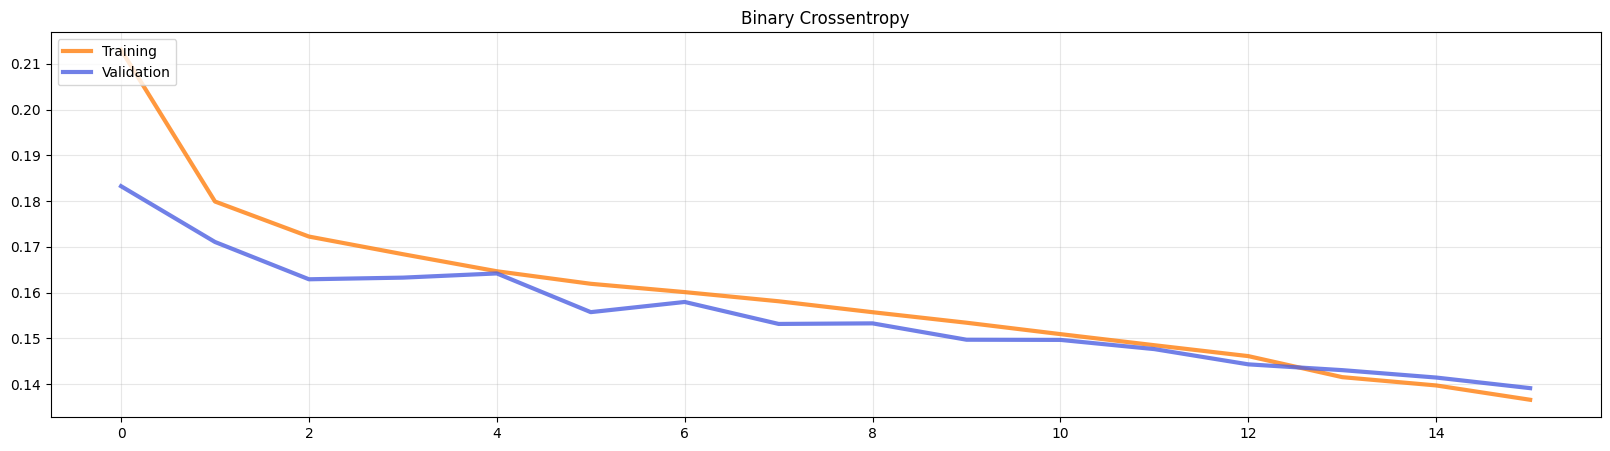

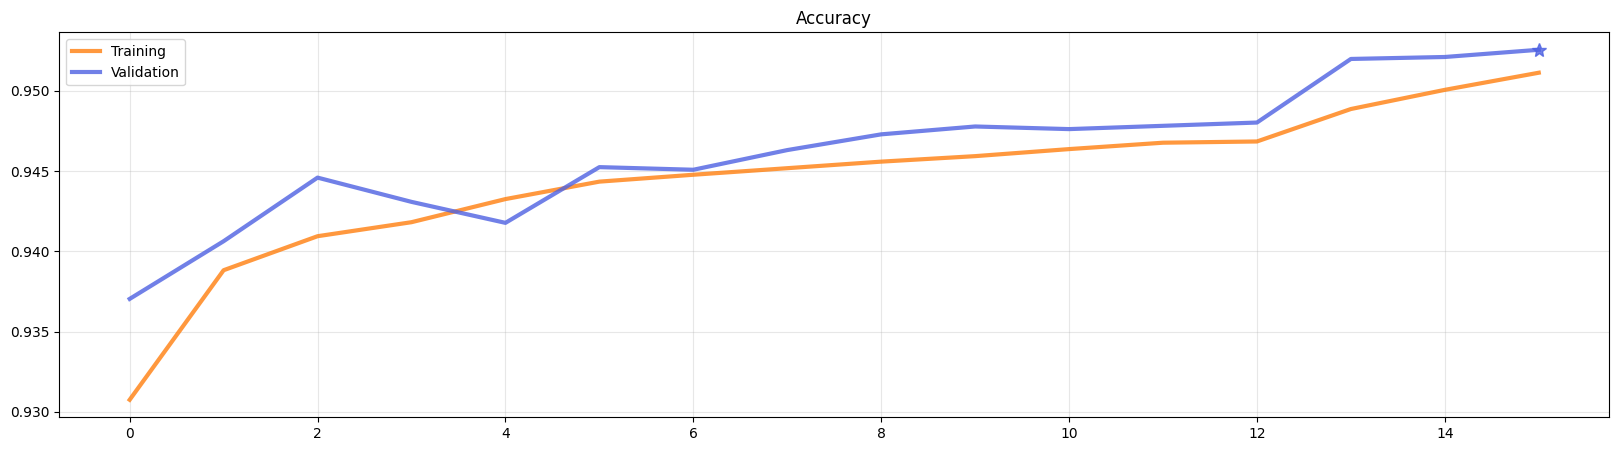

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

## TEST


In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test)

print(predictions)
# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Binary Cross Entropy (BCE)
binary_cross_entropy = tfk.losses.binary_crossentropy(y_test.flatten(), predictions.flatten()).numpy()
print(f"Binary Cross Entropy: {binary_cross_entropy}")

threshold = 0.5

# Convert probabilities to 0 or 1 based on the threshold
binary_predictions = (predictions >= threshold).astype(int)
print(binary_predictions)

875/875 [==============================] - 3s 3ms/step
[[0.00073456]
 [0.00077787]
 [0.14083572]
 ...
 [0.00143828]
 [0.00031114]
 [0.00276424]]
Predictions shape: (27986, 1)
Binary Cross Entropy: 0.18949446082115173
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


Accuracy: 0.9236
Precision: 0.9043
Recall: 0.8317
F1: 0.8619


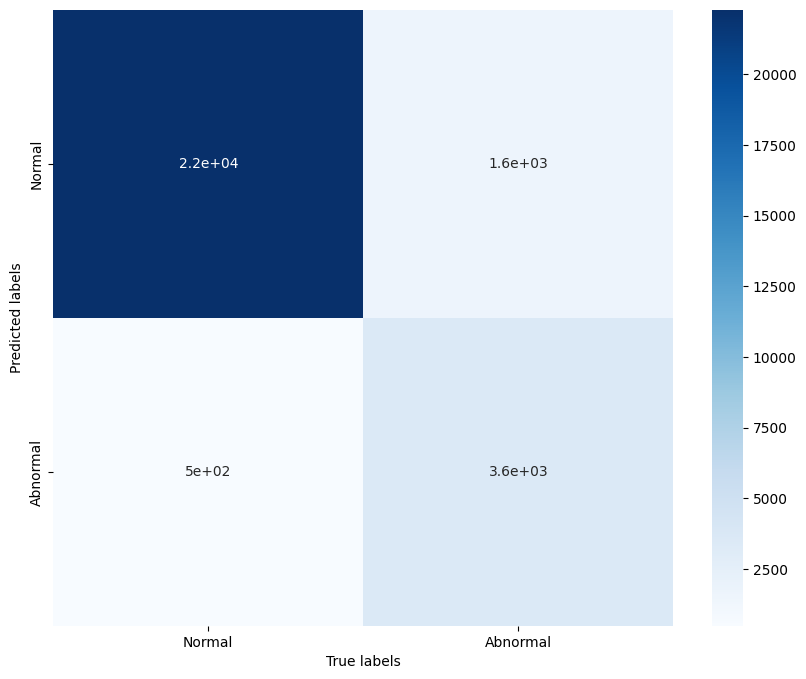

[[22276   500]
 [ 1639  3571]]


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, binary_predictions[:, 0])

# Compute classification metrics
accuracy = accuracy_score(y_test,binary_predictions[:, 0])
precision = precision_score( y_test,binary_predictions[:, 0], average='macro')
recall = recall_score(y_test,binary_predictions[:, 0], average='macro')
f1 = f1_score(y_test,binary_predictions[:, 0], average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T,annot=True, xticklabels=list(['Normal','Abnormal']), yticklabels=list(['Normal','Abnormal']), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

print(cm)

In [ ]:
binary_predictions[:, 0]

array([1, 1, 1, ..., 1, 1, 1])